## Introduction

This project aims to develop a simple text classification system using large language models (LLMs). The model is tasked with categorising travel-related questions into predefined classes. The approach includes prompt design, zero-shot and few-shot testing, as well as supervised fine-tuning (SFT), followed by performance evaluation using metrics such as accuracy.

### Research Questions

1. How can LLMs be effectively optimized for travel-related text classification tasks?
2. What are the differences in performance between zero-shot, one-shot, and few-shot prompting for travel question classification?
3. How does SFT impact model performance in travel classification tasks?
4. What additional improvements can be achieved by leveraging advanced prompting and fine-tuning strategies?


### **Summary**

#### **1. Data Loading and Preparation:**
- A dataset of 5000 travel-related questions is loaded, cleaned, and split into training (4000), validation (300), and test (700) sets.
- Each question is categorized into one of the predefined classes: **Things to Do (TTD)**, **Travel Guide (TGU)**, **Accommodation (ACM)**, **Transport (TRS)**, **Weather (WTH)**, **Food (FOD)**, and **Entertainment (ENT)**.
- The dataset is formatted into a structured form for input to the LLMs.

#### **2. Model Selection and Loading:**
- Multiple models are considered, with the primary focus on compact models such as **Phi 3.5 mini-instruct** from Unsloth, which is efficient for zero-shot and few-shot learning tasks.
- The model and tokenizer are loaded, with tokenization adjustments such as adding a padding token if necessary.
- **4-bit quantization** is used to optimise memory usage without sacrificing much performance.

#### **3. Prompt Engineering:**
- Various prompt templates are designed to test the classification performance of the models. The templates range from concise, direct prompts to more detailed Chain of Thought (CoT) prompts.
- These prompts guide the model in understanding the travel question and mapping it to one of the predefined classes.
- Prompts include zero-shot, one-shot, and three-shot examples to test how well the model performs with varying amounts of context.

#### **4. Evaluation:**
- The prompts are evaluated on small test samples and full test datasets, with results being analyzed in terms of accuracy.
- **Zero-shot** and **few-shot** learning evaluations are performed on the test dataset, comparing the accuracy across different prompt designs and shot levels.
- Classification metrics such as precision, recall, and F1-score are reported for each class.
- **Misclassification analysis** is also performed to understand where the model struggles, identifying incorrect predictions and their possible causes.

#### **5. Fine-Tuning with ORPO:**
- The code includes SFT using **Odds Ratio Preference Optimization (ORPO)**, a method that merges supervised fine-tuning with preference-based learning.
- The **ORPO** configuration optimizes the model based on chosen/rejected responses for each prompt, further refining the model's ability to classify questions accurately.

#### **6. Post-Fine-Tuning Evaluation:**
- After fine-tuning with ORPO, the model's performance is re-evaluated on the test set to measure improvements.
- Post-fine-tuning results show significant accuracy gains, with **Phi 3.5 mini-instruct** reaching an accuracy of **82.86%**, up from 62% in zero-shot evaluation, and **Gemma 2 9B-it** reaching an accuracy of **87.71%**, up from 69.71% in zero-shot evaluation.

---

### **Conclusion**

The project successfully demonstrates the use of compact language models like **Phi 3.5 mini-instruct** in classifying travel-related questions. By leveraging effective prompt engineering, few-shot learning, and **ORPO**-based fine-tuning, the model's accuracy improves significantly. The process involves careful dataset preparation, prompt design, and iterative evaluation.

---

In [ ]:
%pip install -q datasets trl bitsandbytes peft unsloth # accelerate
#%pip install -U -q transformers==4.44.2 torch==2.4.1
#%pip uninstall -q torchaudio torchvision -y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.7/164.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import os
from trl import SFTTrainer, ORPOConfig, ORPOTrainer
from unsloth import FastLanguageModel, PatchDPOTrainer, is_bfloat16_supported
import tqdm
import random
from datasets import Dataset
from google.colab import drive
from transformers import Trainer, TrainingArguments, AutoTokenizer, BitsAndBytesConfig, AutoModelForCausalLM
#from transformers import pipeline, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig
#from kaggle_secrets import UserSecretsClient
from sklearn.metrics import classification_report, confusion_matrix

# Kaggle T4 x2 or P100 GPU
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
from huggingface_hub import login
login(HF_TOKEN)
#output_directory = "/kaggle/working/outputs/"
#os.makedirs(output_directory, exist_ok=True)

# Colab T4 - free tier
# Mount Google Drive
drive.mount('/content/gdrive')
output_directory = '/content/gdrive/MyDrive/outputs/'
os.makedirs(output_directory, exist_ok=True)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Mounted at /content/gdrive


#### Dataset Loading & EDA/Cleaning

In [ ]:
#Detecting file encoding
import requests
import chardet

url = 'https://github.com/suralk/travel_domain_data/raw/master/5000TravelQuestionsDataset.csv'
response = requests.get(url)
raw_data = response.content
result = chardet.detect(raw_data)
encoding = result['encoding']
encoding

'ISO-8859-1'

Loading data, verifying completeness, cleaning empty spaces in coarse classes, removing fine class details and checking class imbalance.

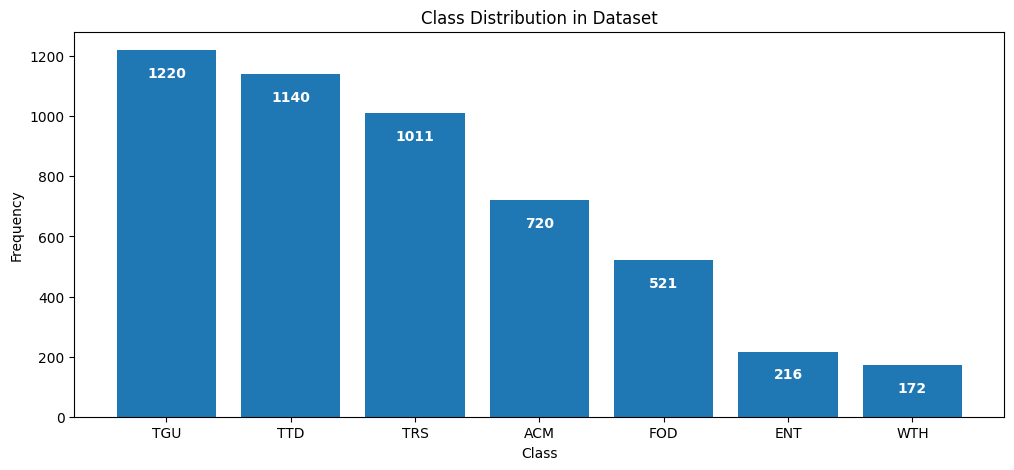

question    0
class       0
dtype: int64


,question,class
0,What are the special things we (husband and me...,TTD
1,What are the companies which organize shark fe...,TTD
2,Is it safe for female traveller to go alone to...,TGU
3,What are the best places around Cape Town for ...,TTD
4,What are the best places to stay for a family ...,ACM
...,...,...
4995,What is the best area to be based for sightsee...,TTD
4996,What are the good value traditional bars and r...,FOD
4997,What are the hotels near Alicante bus station?,ACM
4998,Where to stay in La Gomera to mountain biking?,TTD


In [ ]:
# Step 1: Data Loading & Cleaning

#url = 'https://github.com/suralk/travel_domain_data/raw/master/5000TravelQuestionsDataset.csv'
travel_df = pd.read_csv(url, header=None, names=['question', 'class'], usecols=[0, 1], encoding=encoding) #'ISO-8859-1'

# Remove unnecessary columns and clean dataset
travel_df['question'] = travel_df['question'].str.strip()
travel_df['class'] = travel_df['class'].str.strip().str[:3]  # Ensure each class has only 3 letters, remove empty spaces
class_descriptions = {
    'TTD': 'things to do',
    'TGU': 'travel guide',
    'ACM': 'accommodation',
    'TRS': 'transport',
    'WTH': 'weather',
    'FOD': 'food',
    'ENT': 'entertainment'
}
possible_classes = list(class_descriptions.keys())
label_mapping = {label: idx for idx, label in enumerate(class_descriptions.keys())}
descriptions = ', '.join([f"{key} ({value})" for key, value in class_descriptions.items()])

# Class distribution plot
plt.figure(figsize=(12, 5))
class_counts = travel_df['class'].value_counts()
bars = plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 100, str(bar.get_height()), ha='center', va='bottom', color='white', fontweight='bold')
plt.show()

print(travel_df.isnull().sum())
travel_df

#### Data Split

There is a considerable class imbalance, so will use stratify option when spliting dataset.

In [ ]:
# STEP 2: Data Split
# Filter dataset for the relevant classes
travel_df = travel_df[travel_df['class'].isin(class_descriptions.keys())].reset_index(drop=True)

# Map class labels to integers
travel_df['label'] = travel_df['class'].map(label_mapping)

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(
    travel_df, train_size=4000, stratify=travel_df['class'], random_state=42)
val_data, test_data = train_test_split(
    temp_data, test_size=0.7, stratify=temp_data['class'], random_state=42)

# Reset indices
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_data.to_csv(f"{output_directory}/train_data.csv", index=False)
val_data.to_csv(f"{output_directory}/val_data.csv", index=False)
test_data.to_csv(f"{output_directory}/test_data.csv", index=False)

# Convert datasets for testing and training
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Print the count per class for each split
counts = travel_df['class'].value_counts()
print("Training set class distribution:\n", train_data['class'].value_counts())
print("Validation set class distribution:\n", val_data['class'].value_counts())
print("Test set class distribution:\n", test_data['class'].value_counts())

Training set class distribution:
 class
TGU    976
TTD    912
TRS    809
ACM    576
FOD    417
ENT    173
WTH    137
Name: count, dtype: int64
Validation set class distribution:
 class
TGU    73
TTD    68
TRS    61
ACM    43
FOD    31
ENT    13
WTH    11
Name: count, dtype: int64
Test set class distribution:
 class
TGU    171
TTD    160
TRS    141
ACM    101
FOD     73
ENT     30
WTH     24
Name: count, dtype: int64


### HUGGING FACE MODELS
Used for initial testing of the prompt design and for comparison of models with Unsloth's quantized models.

In [ ]:
#STEP 3: Load Model
# https://pair-code.github.io/llm-comparator/
# https://techcommunity.microsoft.com/t5/ai-azure-ai-services-blog/discover-the-new-multi-lingual-high-quality-phi-3-5-slms/ba-p/4225280


# All models using temperature 0.1, testing done in Kaggle's P100 using random 8 sample questions:
#model_name = "google/gemma-2b-it" # best prompt 2 w/ 42.86% accuracy (fast, but weak!)
#model_name = "google/gemma-2-9b-it" # best prompt 3/4 w/ 90% & 100% accuracy (different seeds, slow but the best)
#model_name = "meta-llama/Llama-3.2-3B-Instruct" #best prompt 3/4 w/ 57.14% accuracy (fast, average)
#model_name = "microsoft/Phi-3.5-mini-instruct" #best prompt 3 w/ 85.71% & 90% accuracy (different seed, medium fast, good) < improved from 71.43% (prompt eng.)

# Load tokenizer and model
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModelForCausalLM.from_pretrained(
#    model_name,
#    torch_dtype=torch.float16,
#    device_map="auto",
#    low_cpu_mem_usage=True,
#    trust_remote_code=True,
#)

# Tokenizer padding token
#if tokenizer.pad_token is None:
#    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
#    model.resize_token_embeddings(tokenizer.vocab_size) #len(tokenizer)) is giving warning

### UNSLOTH

In [ ]:
#STEP 3: Load Model

# Install Flash Attention 2 for softcapping support
#if torch.cuda.get_device_capability()[0] >= 8:
#    %pip install --no-deps packaging ninja einops "flash-attn>=2.6.3"

max_seq_length = 512 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3.5-mini-instruct",
    #model_name = "unsloth/gemma-2-9b-it-bnb-4bit", #unsloth/gemma-2-9b-bnb-4bit
    #model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",  #"unsloth/Qwen2.5-3B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Tokenizer padding token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
    model.resize_token_embeddings(tokenizer.vocab_size) #len(tokenizer)) is giving warning

FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2024.10.5: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Unsloth: We fixed a gradient accumulation bug, but it seems like you don't have the latest transformers version!
Please update transformers, TRL and unsloth via:
`pip install --upgrade --no-cache-dir unsloth git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git`


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32064, 3072)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LongRopeRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-0

#### Prompt Engineering & Evaluation

In [ ]:
# STEP 4: PROMPT Engineering
# https://www.promptingguide.ai/techniques
# https://arxiv.org/abs/2305.08291
# https://arxiv.org/abs/2302.12822
# https://arxiv.org/abs/2402.07927
# https://dottxt-ai.github.io/outlines/ Did not use but could potentially improve results.


# Formatting function for prompts (for training)
def formatting_prompts_func_training(example):
    text = f"### Question: {example['question']}\n### Answer: {example['class']}"
    return {'text': text}

# Formatting function for prompts (for evaluation)
def formatting_prompts_func_eval(example):
    text = f"### Question: {example['question']}"
    return {'text': text}

# Apply formatting to datasets
train_dataset = train_dataset.map(formatting_prompts_func_training)
val_dataset = val_dataset.map(formatting_prompts_func_eval)
test_dataset = test_dataset.map(formatting_prompts_func_eval)


# Prompt 1 (Basic)
prompt_template_1 = f"""Classify the travel question into one of the classes {possible_classes}. Answer only the category's class key.
Examples: {{examples}}
Question: {{}}
Answer:"""

# Prompt 2 (Concise & direct, often good for tiny models)
prompt_template_2 = f"""Given the following travel question and descriptions of classes {descriptions}, determine which class {possible_classes} the question best fits into. Answer just the class 3-letters.
Examples (if any):
{{examples}}
Question: {{}}
Answer:"""

# Prompt 3 (Concise & direct, often good for tiny models, improvement after removed keywords)
prompt_template_3 = f"""Given the following travel related question and descriptions of possible classes {descriptions}.
Use reasoning to identify the question's overall intent and type of information being asked, to determine which class among {possible_classes} the question best fits into.
Answer MUST contain ONLY the class 3-letters, nothing else.
Examples (if any):
{{examples}}

Question: {{}}

Answer:"""

# Prompt 4 - NEW (Longer format with COT reasoning, best for larger models; improvement after removed keywords, added re-evaluation)
prompt_template_4 = f"""Given the following travel-domain question and descriptions of possible classes {descriptions}.
Think step by step, considering the question's overall goal carefully and any examples provided, to determine which class the question best fits into:
1. Paraphrase the question to help identify the main intent and type of information being asked.
2. Match the original question's context with the most suitable class {possible_classes}.
3. If any are given, leverage the following examples to get a better grasp of class nuances:

{{examples}}

4. Re-evaluate your answer.
5. Remember answers MUST be ONLY the class 3-letters, nothing else.

Question: {{}}

Answer:"""


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [ ]:
# STEP 5: Prompt Evaluation

def evaluate_prompt(eval_dataset, prompt_template, shots=0):
    all_predictions = []
    all_labels = eval_dataset['class']
    incorrect_samples = {cls: [] for cls in possible_classes}

    # Prepare few-shot examples from the training set
    if shots > 0:
        few_shot_examples = train_dataset.shuffle(seed=42).select(range(shots))
        examples = []
        for ex in few_shot_examples:
            example_text = f"Question: {ex['question']}\nAnswer: {ex['class']}"
            examples.append(example_text)
        examples_text = "\n\n".join(examples)
    else:
        examples_text = ""

    model.eval()

    for idx in range(len(eval_dataset)):
        question_text = eval_dataset[idx]['text'].split("### Question: ")[-1]
        prompt = prompt_template.replace("{examples}", examples_text).format(question_text)

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,  # should be more than enough!
                #do_sample=True, # False works well for classification >> more deterministic (if False, don't use temperature nor top_p/_k)
                temperature=0.1,
                top_p=0.9,
                top_k=5,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id,
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Extract answer from the generated text
        answer = generated_text.split('Answer:')[-1].strip().upper()[:3] # post-processing, extract only first 3-letters of answer
        if answer in possible_classes:
            all_predictions.append(answer)
        else:
            all_predictions.append('TGU') # replacing unknown with most probable class TGU as default instead

        # Collect incorrect samples for analysis
        if all_predictions[-1] != all_labels[idx]:
            true_class = all_labels[idx]
            if len(incorrect_samples[true_class]) < 2:
                incorrect_samples[true_class].append({
                    'question': question_text.strip(),
                    'prediction': all_predictions[-1],
                    'true_label': true_class,
                    'prompt': prompt,
                    'generated_text': generated_text
                })

    # Calculate accuracy
    correct = sum(p == l for p, l in zip(all_predictions, all_labels))
    accuracy = correct / len(all_labels)

    return all_predictions, accuracy, incorrect_samples

# Select n random samples from the test set for initial zero-shot testing
test_sample = test_dataset.shuffle(seed=42).select(range(8))

# Evaluate each prompt on the test sample
prompts = {
    'Prompt 1': prompt_template_1,
    'Prompt 2': prompt_template_2,
    'Prompt 3': prompt_template_3,
    'Prompt 4': prompt_template_4
}

prompt_accuracies = {}

for prompt_name, prompt_template in prompts.items():
    print(f"\nEvaluating {prompt_name} on 8-sample zero-shot...")
    predictions, accuracy, _ = evaluate_prompt(test_sample, prompt_template, shots=0)
    prompt_accuracies[prompt_name] = accuracy
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(test_sample['class'], predictions, labels=possible_classes, zero_division=0))


Evaluating Prompt 1 on 8-sample zero-shot...
Accuracy: 0.2500
Classification Report:
              precision    recall  f1-score   support

         TTD       0.00      0.00      0.00         2
         TGU       0.20      1.00      0.33         1
         ACM       0.00      0.00      0.00         2
         TRS       0.00      0.00      0.00         1
         WTH       1.00      1.00      1.00         1
         FOD       0.00      0.00      0.00         1
         ENT       0.00      0.00      0.00         0

    accuracy                           0.25         8
   macro avg       0.17      0.29      0.19         8
weighted avg       0.15      0.25      0.17         8


Evaluating Prompt 2 on 8-sample zero-shot...
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

         TTD       1.00      1.00      1.00         2
         TGU       1.00      1.00      1.00         1
         ACM       1.00      1.00      1.00         2
         TRS  

#### n-Shot Evaluation on full Test set

Using Prompt 3:

In [ ]:
# STEP 6: Shot Evaluation

# Evaluate the best prompt on the full test set
best_prompt = prompt_template_3

# Zero-shot evaluation
print("\nZero-shot Evaluation on the full test set:")
predictions_zero_shot, accuracy_zero_shot, incorrect_zero_shot = evaluate_prompt(test_dataset, best_prompt, shots=0)
print(f"Zero-shot Accuracy: {accuracy_zero_shot:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_zero_shot, labels=possible_classes, zero_division=0))

# One-shot evaluation
print("\nOne-shot Evaluation on the full test set:")
predictions_one_shot, accuracy_one_shot, incorrect_one_shot = evaluate_prompt(test_dataset, best_prompt, shots=1)
print(f"One-shot Accuracy: {accuracy_one_shot:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_one_shot, labels=possible_classes, zero_division=0))

# Three-shot evaluation
print("\nThree-shot Evaluation on the full test set:")
predictions_three_shot, accuracy_three_shot, incorrect_three_shot = evaluate_prompt(test_dataset, best_prompt, shots=3)
print(f"Three-shot Accuracy: {accuracy_three_shot:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_three_shot, labels=possible_classes, zero_division=0))


Zero-shot Evaluation on the full test set:
Zero-shot Accuracy: 0.6271
Classification Report:
              precision    recall  f1-score   support

         TTD       0.83      0.46      0.59       160
         TGU       0.60      0.16      0.26       171
         ACM       0.79      0.96      0.87       101
         TRS       0.51      0.99      0.68       141
         WTH       0.55      1.00      0.71        24
         FOD       0.63      0.84      0.72        73
         ENT       0.55      0.53      0.54        30

    accuracy                           0.63       700
   macro avg       0.64      0.71      0.62       700
weighted avg       0.66      0.63      0.58       700


One-shot Evaluation on the full test set:
One-shot Accuracy: 0.6114
Classification Report:
              precision    recall  f1-score   support

         TTD       0.70      0.41      0.51       160
         TGU       0.69      0.27      0.39       171
         ACM       0.64      0.95      0.76       101


Using old Prompt 4:

In [ ]:
# STEP 6: Shot Evaluation

prompt_4_OLD = f"""Given the following travel-domain question and descriptions of possible classes {descriptions}.
Think step by step, considering the question's overall goal carefully and any examples provided, to determine which class the question best fits into:
1. Identify the main intent and type of information being asked.
2. Match the question's context with the most suitable class {possible_classes}.
3. If any are given, leverage the following examples to get a better grasp of class nuances:

{{examples}}

4. Re-evaluate your answer.
5. Remember answers MUST be ONLY the class 3-letters, nothing else.

Question: {{}}

Answer:"""

# Evaluate the best prompt on the full test set
best_prompt = prompt_4_OLD

# Zero-shot evaluation
print("\nZero-shot Evaluation on the full test set:")
predictions_zero_shot, accuracy_zero_shot, incorrect_zero_shot = evaluate_prompt(test_dataset, best_prompt, shots=0)
print(f"Zero-shot Accuracy: {accuracy_zero_shot:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_zero_shot, labels=possible_classes, zero_division=0))

# One-shot evaluation
print("\nOne-shot Evaluation on the full test set:")
predictions_one_shot, accuracy_one_shot, incorrect_one_shot = evaluate_prompt(test_dataset, best_prompt, shots=1)
print(f"One-shot Accuracy: {accuracy_one_shot:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_one_shot, labels=possible_classes, zero_division=0))

# Three-shot evaluation
print("\nThree-shot Evaluation on the full test set:")
predictions_three_shot, accuracy_three_shot, incorrect_three_shot = evaluate_prompt(test_dataset, best_prompt, shots=3)
print(f"Three-shot Accuracy: {accuracy_three_shot:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_three_shot, labels=possible_classes, zero_division=0))


Zero-shot Evaluation on the full test set:
Zero-shot Accuracy: 0.5900
Classification Report:
              precision    recall  f1-score   support

         TTD       0.82      0.37      0.51       160
         TGU       0.83      0.09      0.16       171
         ACM       0.67      0.96      0.79       101
         TRS       0.48      0.99      0.65       141
         WTH       0.44      1.00      0.62        24
         FOD       0.71      0.85      0.78        73
         ENT       0.50      0.57      0.53        30

    accuracy                           0.59       700
   macro avg       0.64      0.69      0.57       700
weighted avg       0.69      0.59      0.52       700


One-shot Evaluation on the full test set:
One-shot Accuracy: 0.6243
Classification Report:
              precision    recall  f1-score   support

         TTD       0.77      0.39      0.51       160
         TGU       0.69      0.27      0.39       171
         ACM       0.63      0.96      0.76       101


Using New Prompt 4:

In [ ]:
# STEP 6: Shot Evaluation

# Evaluate the best prompt on the full test set
best_prompt = prompt_template_4 #NEW

# Zero-shot evaluation
print("\nZero-shot Evaluation on the full test set:")
predictions_zero_shot, accuracy_zero_shot, incorrect_zero_shot = evaluate_prompt(test_dataset, best_prompt, shots=0)
print(f"Zero-shot Accuracy: {accuracy_zero_shot:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_zero_shot, labels=possible_classes, zero_division=0))

# One-shot evaluation
print("\nOne-shot Evaluation on the full test set:")
predictions_one_shot, accuracy_one_shot, incorrect_one_shot = evaluate_prompt(test_dataset, best_prompt, shots=1)
print(f"One-shot Accuracy: {accuracy_one_shot:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_one_shot, labels=possible_classes, zero_division=0))

# Three-shot evaluation
print("\nThree-shot Evaluation on the full test set:")
predictions_three_shot, accuracy_three_shot, incorrect_three_shot = evaluate_prompt(test_dataset, best_prompt, shots=3)
print(f"Three-shot Accuracy: {accuracy_three_shot:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_three_shot, labels=possible_classes, zero_division=0))


Zero-shot Evaluation on the full test set:
Zero-shot Accuracy: 0.5900
Classification Report:
              precision    recall  f1-score   support

         TTD       0.84      0.38      0.52       160
         TGU       0.86      0.07      0.13       171
         ACM       0.70      0.97      0.81       101
         TRS       0.47      0.99      0.64       141
         WTH       0.45      1.00      0.62        24
         FOD       0.71      0.84      0.77        73
         ENT       0.49      0.60      0.54        30

    accuracy                           0.59       700
   macro avg       0.64      0.69      0.58       700
weighted avg       0.71      0.59      0.52       700


One-shot Evaluation on the full test set:
One-shot Accuracy: 0.6186
Classification Report:
              precision    recall  f1-score   support

         TTD       0.76      0.35      0.48       160
         TGU       0.74      0.26      0.39       171
         ACM       0.64      0.96      0.77       101


#### Misclassification Analysis

Extracting only 2 misclassified samples from each class for each of the n-shot runs.

In [ ]:
# STEP 7: Misclassification Analysis

# Function to analyse misclassifications
def analyze_misclassifications(incorrect_samples, setting_name):
    print(f"\nAnalyzing Misclassifications in {setting_name}:")
    for cls in possible_classes:
        mistakes = incorrect_samples.get(cls, [])
        if mistakes:
            print(f"\nClass '{cls}' Misclassifications:")
            for sample in mistakes:
                print(f"- Question: {sample['question']}")
                print(f"  Predicted: {sample['prediction']}, True Label: {sample['true_label']}")
                print(f"  Model Output:\n{sample['generated_text']}\n\n")
                if mistakes.index(sample) >= 1: # Limit number of samples per class
                    break

# zero-shot misclassifications
analyze_misclassifications(incorrect_zero_shot, "Zero-shot Evaluation")

# one-shot misclassifications
analyze_misclassifications(incorrect_one_shot, "One-shot Evaluation")

# three-shot misclassifications
analyze_misclassifications(incorrect_three_shot, "Three-shot Evaluation")


Analyzing Misclassifications in Zero-shot Evaluation:

Class 'TTD' Misclassifications:
- Question: Is there a constant sandbank at the ocean in Diani beach?
  Predicted: WTH, True Label: TTD
  Model Output:
Given the following travel-domain question and descriptions of possible classes TTD (things to do), TGU (travel guide), ACM (accommodation), TRS (transport), WTH (weather), FOD (food), ENT (entertainment).
Think step by step, considering the question's overall goal carefully and any examples provided, to determine which class the question best fits into:
1. Identify the main intent and type of information being asked.
2. Match the question's context with the most suitable class ['TTD', 'TGU', 'ACM', 'TRS', 'WTH', 'FOD', 'ENT'].
3. If any are given, leverage the following examples to get a better grasp of class nuances:



4. Re-evaluate your answer.
5. Remember answers MUST be ONLY the class 3-letters, nothing else.

Question: Is there a constant sandbank at the ocean in Diani beac

## FINE-TUNING

### Unsloth's Supervised Fine-Tuning (LoRA w/ PEFT)) ORPO (SFT & DPO)

Odds Ratio Preference Optimization (ORPO) by Jiwoo Hong, Noah Lee, and James Thorne merges the Supervised Fine-Tuning (SFT) and Direct Preference Optimization (DPO) steps (https://github.com/xfactlab/orpo)

sources:
https://huggingface.co/docs/trl/en/orpo_trainer and
https://docs.unsloth.ai/get-started/unsloth-notebooks

#### Loading LoRA Adapters with PEFT

In [ ]:
# LoRA Adapters with PEFT
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)


########################
# PROMPT #4 NEW
#f"""Given the following travel-domain question and descriptions of possible classes {descriptions}.
#Think step by step, considering the question's overall goal carefully and any examples provided, to determine which class the question best fits into:
#1. Paraphrase the question to help identify the main intent and type of information being asked.
#2. Match the original question's context with the most suitable class {possible_classes}.
#3. Re-evaluate your answer.
#4. Remember answers MUST be ONLY the class 3-letters, nothing else.

#Question: {{}}

####Answer:"""
####################
#PROMPT #4 OLD
#f"""Given the following travel-domain question and descriptions of possible classes {descriptions}.
#Think step by step, considering the question's overall goal carefully and any examples provided, to determine which class the question best fits into:
#1. Identify the main intent and type of information being asked.
#2. Match the question's context with the most suitable class {possible_classes}.
#3. Re-evaluate your answer.
#4. Remember answers MUST be ONLY the class 3-letters, nothing else.

#Question: {{}}

#The question is most closely related to the class:
####Answer:"""
#######################

# Custom ORPO classification prompt based on the best prompt template
#PROMPT #3
orpo_prompt = f"""Given the following travel related question and descriptions of possible classes {descriptions}.
Use reasoning to identify the question's overall intent and type of information being asked, to determine which class among {possible_classes} the question best fits into.
Answer MUST contain ONLY the class 3-letters, nothing else.

Question: {{}}

###Answer:"""

EOS_TOKEN = tokenizer.eos_token

# Formatting the training, validation, and test sets for ORPO
def format_orpo_prompt(sample):
    question = sample["question"]
    correct_class = sample["class"]
    incorrect_classes = [cls for cls in class_descriptions.keys() if cls != correct_class]
    # ORPOTrainer expects 'prompt', 'chosen', and 'rejected' keys
    sample["prompt"] = orpo_prompt.format(question)
    sample["chosen"] = correct_class + tokenizer.eos_token  # Correct class with EOS token
    sample["rejected"] = ' '.join([cls + tokenizer.eos_token for cls in incorrect_classes])
    #sample["chosen"] = str(correct_class + tokenizer.eos_token)
    #sample["rejected"] = str(' '.join([cls + tokenizer.eos_token for cls in incorrect_classes]))
    return sample

# Apply the formatting function to all datasets
train_dataset_orpo = Dataset.from_pandas(train_data).map(format_orpo_prompt)
val_dataset_orpo = Dataset.from_pandas(val_data).map(format_orpo_prompt)
test_dataset_orpo = Dataset.from_pandas(test_data).map(format_orpo_prompt)

Unsloth 2024.10.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

### ORPO Fine-Tuning Results

#### Phi 3.5 mini Unsloth (prompt #3, 100 steps)
Prompt used:

In [ ]:
#orpo_prompt = f"""Given the following travel related question and descriptions of possible classes {descriptions}.
#Use reasoning to identify the question's overall intent and type of information being asked, to determine which class among {possible_classes} the question best fits into.
#Answer MUST contain ONLY the class 3-letters, nothing else.

#Question: {{}}

###Answer:"""

Fine-Tuning Results:

In [ ]:
# ORPO - Configuration and Trainer Setup
PatchDPOTrainer()  # Patch for DPO Trainer

# ORPO Trainer Setup
orpo_trainer = ORPOTrainer(
    model=model,
    train_dataset=train_dataset_orpo,  # Training dataset with chosen/rejected
    eval_dataset=val_dataset_orpo, # Validation dataset for evaluation during fine-tuning
    tokenizer=tokenizer,
    args=ORPOConfig(
        beta=0.1,
        max_length=1024,
        max_prompt_length=512,
        max_completion_length=56,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=1e-4, #2e-4
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear", # "cosine"
        #num_train_epochs = 1, # 1 for full training run
        max_steps=100,  # None for full run (comment out if using num_train_epochs)
        fp16=not is_bfloat16_supported(),  # Use FP16 if BFloat16 isn't supported
        bf16=is_bfloat16_supported(),  # Use BFloat16 if available
        output_dir="./orpo_results",
        report_to="none", # "wandb"
    ),
)

# Begin ORPO fine-tuning
orpo_trainer.train()

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 100
 "-____-"     Number of trainable parameters = 29,884,416


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen
1,0.288600,-0.024616,-0.775782,1.000000,0.751166,-7.757820,-0.246160,3.529725,-1.002200
2,0.264500,-0.022280,-0.772694,1.000000,0.750414,-7.726944,-0.222801,2.530793,-2.218564
3,0.239900,-0.008757,-0.775709,1.000000,0.766952,-7.757087,-0.087568,2.773026,-1.584617
4,0.232800,-0.035540,-0.789868,1.000000,0.754328,-7.898680,-0.355402,2.286011,-2.178830
5,0.282000,-0.025799,-0.781500,1.000000,0.755701,-7.814999,-0.257987,2.432155,-2.462226
6,0.239900,-0.022800,-0.800751,1.000000,0.777951,-8.007508,-0.227999,2.295989,-2.224709
7,0.207100,-0.005351,-0.787960,1.000000,0.782608,-7.879595,-0.053513,2.534091,-2.238055
8,0.215700,-0.017175,-0.799606,1.000000,0.782431,-7.996058,-0.171747,2.269094,-2.282728
9,0.309600,-0.027658,-0.799657,1.000000,0.771998,-7.996567,-0.276583,2.754296,-1.875098
10,0.277600,-0.020391,-0.799515,1.000000,0.779124,-7.995152,-0.203911,2.672522,-1.748658


TrainOutput(global_step=100, training_loss=0.25794237926602365, metrics={'train_runtime': 309.3339, 'train_samples_per_second': 2.586, 'train_steps_per_second': 0.323, 'total_flos': 0.0, 'train_loss': 0.25794237926602365, 'epoch': 0.2})

In [ ]:
# 100 steps - Phi 3.5 mini Unsloth (prompt #3)
FastLanguageModel.for_inference(model)

# Post-ORPO Zero-shot evaluation
print("\nPost-ORPO Zero-shot Evaluation on the full test set:")
predictions_zero_shot_post, accuracy_zero_shot_post, incorrect_zero_shot_post = evaluate_prompt(test_dataset, orpo_prompt, shots=0)
print(f"Post-ORPO Zero-shot Accuracy: {accuracy_zero_shot_post:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_zero_shot_post, labels=possible_classes, zero_division=0))


Post-ORPO Zero-shot Evaluation on the full test set:
Post-ORPO Zero-shot Accuracy: 0.8286
Classification Report:
              precision    recall  f1-score   support

         TTD       0.77      0.85      0.81       160
         TGU       0.81      0.69      0.75       171
         ACM       0.84      0.91      0.87       101
         TRS       0.89      0.94      0.91       141
         WTH       0.92      0.92      0.92        24
         FOD       0.86      0.89      0.87        73
         ENT       0.75      0.50      0.60        30

    accuracy                           0.83       700
   macro avg       0.83      0.81      0.82       700
weighted avg       0.83      0.83      0.82       700



In [ ]:
# Accuracies
evaluations = ['Zero-shot', '1-shot', '3-shot', 'ORPO-tuned']
accuracies = [accuracy_zero_shot, accuracy_one_shot, accuracy_three_shot, accuracy_zero_shot_post]

results_df = pd.DataFrame({'Evaluation': evaluations, 'Accuracy': accuracies})
print("\nAccuracy Comparison Table:")
print(results_df)


Accuracy Comparison Table:
   Evaluation  Accuracy
0   Zero-shot  0.627143
1      1-shot  0.631429
2      3-shot  0.634297
3  ORPO-tuned  0.828571


In [ ]:

# Fine-Tuning zero-shot misclassifications
analyze_misclassifications(incorrect_zero_shot_post, "ORPO-tuned Zero-shot Evaluation")



Analyzing Misclassifications in ORPO-tuned Zero-shot Evaluation:

Class 'TTD' Misclassifications:
- Question: Would 700 pound be enough to spend for week in Sunny Beach ?
  Predicted: TGU, True Label: TTD
  Model Output:
Given the following travel related question and descriptions of possible classes TTD (things to do), TGU (travel guide), ACM (accommodation), TRS (transport), WTH (weather), FOD (food), ENT (entertainment).
Use reasoning to identify the question's overall intent and type of information being asked, to determine which class among ['TTD', 'TGU', 'ACM', 'TRS', 'WTH', 'FOD', 'ENT'] the question best fits into.
Answer MUST contain ONLY the class 3-letters, nothing else.

Question: Would 700 pound be enough to spend for week in Sunny Beach ?

###Answer:TGU


- Question: Is it best to purchase entry tickets beforehand or to pay at the gate at splash park Canggu?
  Predicted: TGU, True Label: TTD
  Model Output:
Given the following travel related question and descriptions of 

#### Phi 3.5 mini Unsloth (NEW prompt #4, 100 steps)
Prompt used:

In [ ]:
#PROMPT #4 NEW
#orpo_prompt = f"""Given the following travel-domain question and descriptions of possible classes {descriptions}.
#Think step by step, considering the question's overall goal carefully and any examples provided, to determine which class the question best fits into:
#1. Paraphrase the question to help identify the main intent and type of information being asked.
#2. Match the original question's context with the most suitable class {possible_classes}.
#3. Re-evaluate your answer.
#4. Remember answers MUST be ONLY the class 3-letters, nothing else.

#Question: {{}}

#Answer:"""

Fine-Tuning Results:

In [ ]:
# ORPO - Configuration and Trainer Setup
PatchDPOTrainer()  # Patch for DPO Trainer

# ORPO Trainer Setup
orpo_trainer = ORPOTrainer(
    model=model,
    train_dataset=train_dataset_orpo,  # Training dataset with chosen/rejected
    eval_dataset=val_dataset_orpo, # Validation dataset for evaluation during fine-tuning
    tokenizer=tokenizer,
    args=ORPOConfig(
        beta=0.1,
        max_length=1024,
        max_prompt_length=512,
        max_completion_length=56,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=2e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear", # "cosine"
        #num_train_epochs = 1, # 1 for full training run
        max_steps=100,  # None for full run (comment out if using num_train_epochs)
        fp16=not is_bfloat16_supported(),  # Use FP16 if BFloat16 isn't supported
        bf16=is_bfloat16_supported(),  # Use BFloat16 if available
        output_dir="./orpo_results",
        report_to="none", # "wandb"
    ),
)

# Begin ORPO fine-tuning
orpo_trainer.train()

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 100
 "-____-"     Number of trainable parameters = 29,884,416


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen
1,0.947800,-0.467348,-0.836734,1.000000,0.369385,-8.367337,-4.673484,3.457539,-0.048899
2,0.300500,-0.125164,-0.805755,1.000000,0.680591,-8.057547,-1.251639,7.345361,4.051510
3,0.204600,-0.011913,-0.787992,1.000000,0.776079,-7.879921,-0.119132,7.349695,4.170848
4,0.188400,-0.028722,-0.788346,1.000000,0.759625,-7.883463,-0.287216,5.425983,2.165790
5,0.214500,-0.019916,-0.783054,1.000000,0.763138,-7.830544,-0.199164,4.632450,0.945412
6,0.177700,-0.022411,-0.799387,1.000000,0.776976,-7.993868,-0.224109,3.391618,0.065917
7,0.153900,-0.003918,-0.809885,1.000000,0.805967,-8.098848,-0.039175,3.219368,-0.475121
8,0.158700,-0.014083,-0.810499,1.000000,0.796416,-8.104986,-0.140829,2.788406,-0.707934
9,0.224700,-0.024480,-0.819291,1.000000,0.794811,-8.192911,-0.244801,3.035679,-0.588088
10,0.205600,-0.029149,-0.807360,1.000000,0.778211,-8.073597,-0.291485,2.818508,-0.664625


TrainOutput(global_step=100, training_loss=0.20096563056111336, metrics={'train_runtime': 415.8631, 'train_samples_per_second': 1.924, 'train_steps_per_second': 0.24, 'total_flos': 0.0, 'train_loss': 0.20096563056111336, 'epoch': 0.2})

In [ ]:
# 100 steps - Phi 3.5 mini Unsloth (NEW prompt #4)
FastLanguageModel.for_inference(model)

# Post-ORPO Zero-shot evaluation
print("\nPost-ORPO Zero-shot Evaluation on the full test set:")
predictions_zero_shot_post, accuracy_zero_shot_post, incorrect_zero_shot_post = evaluate_prompt(test_dataset, orpo_prompt, shots=0)
print(f"Post-ORPO Zero-shot Accuracy: {accuracy_zero_shot_post:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_zero_shot_post, labels=possible_classes, zero_division=0))


Post-ORPO Zero-shot Evaluation on the full test set:
Post-ORPO Zero-shot Accuracy: 0.8171
Classification Report:
              precision    recall  f1-score   support

         TTD       0.79      0.81      0.80       160
         TGU       0.71      0.73      0.72       171
         ACM       0.87      0.86      0.87       101
         TRS       0.91      0.90      0.91       141
         WTH       0.92      0.92      0.92        24
         FOD       0.90      0.86      0.88        73
         ENT       0.69      0.60      0.64        30

    accuracy                           0.82       700
   macro avg       0.83      0.81      0.82       700
weighted avg       0.82      0.82      0.82       700



In [ ]:
# Accuracies
evaluations = ['Zero-shot', '1-shot', '3-shot', 'ORPO-tuned']
accuracies = [accuracy_zero_shot, accuracy_one_shot, accuracy_three_shot, accuracy_zero_shot_post]

results_df = pd.DataFrame({'Evaluation': evaluations, 'Accuracy': accuracies})
print("\nAccuracy Comparison Table:")
print(results_df)


Accuracy Comparison Table:
   Evaluation  Accuracy
0   Zero-shot  0.627143
1      1-shot  0.612857
2      3-shot  0.631429
3  ORPO-tuned  0.817143


#### Phi 3.5 mini Unsloth (OLD prompt #4, 100 steps)
Prompt used:

In [ ]:
#orpo_prompt = f"""Given the following travel-domain question and descriptions of possible classes {descriptions}.
#Think step by step, considering the question's overall goal carefully and any examples provided, to determine which class the question best fits into:
#1. Identify the main intent and type of information being asked.
#2. Match the question's context with the most suitable class {possible_classes}.
#3. Re-evaluate your answer.
#4. Remember answers MUST be ONLY the class 3-letters, nothing else.

#Question: {{}}

#The question is most closely related to the class:
####Answer:"""

Fine-Tuning Results:

In [ ]:
# ORPO - Configuration and Trainer Setup
PatchDPOTrainer()  # Patch for DPO Trainer

# ORPO Trainer Setup
orpo_trainer = ORPOTrainer(
    model=model,
    train_dataset=train_dataset_orpo,  # Training dataset with chosen/rejected
    eval_dataset=val_dataset_orpo, # Validation dataset for evaluation during fine-tuning
    tokenizer=tokenizer,
    args=ORPOConfig(
        beta=0.1,
        max_length=1024,
        max_prompt_length=512,
        max_completion_length=56,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=2e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear", # "cosine"
        #num_train_epochs = 1, # 1 for full training run
        max_steps=100,  # None for full run (comment out if using num_train_epochs)
        fp16=not is_bfloat16_supported(),  # Use FP16 if BFloat16 isn't supported
        bf16=is_bfloat16_supported(),  # Use BFloat16 if available
        output_dir="./orpo_results",
        report_to="none", # "wandb"
    ),
)

# Begin ORPO fine-tuning
orpo_trainer.train()

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 100
 "-____-"     Number of trainable parameters = 29,884,416


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen
1,3.408800,-0.031189,-0.824858,1.000000,0.793668,-8.248578,-0.311895,4.914546,0.479605
2,1.574000,-0.042708,-0.780471,1.000000,0.737764,-7.804712,-0.427077,16.948563,13.762262
3,1.036100,-0.020706,-0.767853,1.000000,0.747147,-7.678531,-0.207056,21.888920,20.071976
4,0.794700,-0.023096,-0.789528,1.000000,0.766432,-7.895278,-0.230956,18.806637,16.277815
5,0.564500,-0.019647,-0.781338,1.000000,0.761691,-7.813380,-0.196473,18.404392,15.512014
6,0.360100,-0.014310,-0.798413,1.000000,0.784103,-7.984128,-0.143096,15.914656,13.454845
7,0.220700,-0.008575,-0.794699,1.000000,0.786124,-7.946991,-0.085753,11.987940,8.914098
8,0.202300,-0.031445,-0.802618,1.000000,0.771173,-8.026181,-0.314449,6.661379,3.600470
9,0.260100,-0.039480,-0.805251,1.000000,0.765771,-8.052509,-0.394804,3.829553,0.502392
10,0.223900,-0.020604,-0.801267,1.000000,0.780663,-8.012670,-0.206040,3.089312,-0.275560


TrainOutput(global_step=100, training_loss=0.2626627238094807, metrics={'train_runtime': 424.4793, 'train_samples_per_second': 1.885, 'train_steps_per_second': 0.236, 'total_flos': 0.0, 'train_loss': 0.2626627238094807, 'epoch': 0.2})

In [ ]:
# 100 steps - Phi 3.5 mini Unsloth (OLD prompt #4)
FastLanguageModel.for_inference(model)

# Post-ORPO Zero-shot evaluation
print("\nPost-ORPO Zero-shot Evaluation on the full test set:")
predictions_zero_shot_post, accuracy_zero_shot_post, incorrect_zero_shot_post = evaluate_prompt(test_dataset, orpo_prompt, shots=0)
print(f"Post-ORPO Zero-shot Accuracy: {accuracy_zero_shot_post:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_zero_shot_post, labels=possible_classes, zero_division=0))


Post-ORPO Zero-shot Evaluation on the full test set:
Post-ORPO Zero-shot Accuracy: 0.8157
Classification Report:
              precision    recall  f1-score   support

         TTD       0.76      0.85      0.80       160
         TGU       0.77      0.62      0.69       171
         ACM       0.83      0.89      0.86       101
         TRS       0.88      0.95      0.91       141
         WTH       0.92      0.96      0.94        24
         FOD       0.90      0.88      0.89        73
         ENT       0.72      0.60      0.65        30

    accuracy                           0.82       700
   macro avg       0.82      0.82      0.82       700
weighted avg       0.81      0.82      0.81       700



In [ ]:
# Accuracies
evaluations = ['Zero-shot', '1-shot', '3-shot', 'ORPO-tuned']
accuracies = [accuracy_zero_shot, accuracy_one_shot, accuracy_three_shot, accuracy_zero_shot_post]

results_df = pd.DataFrame({'Evaluation': evaluations, 'Accuracy': accuracies})
print("\nAccuracy Comparison Table:")
print(results_df)


Accuracy Comparison Table:
   Evaluation  Accuracy
0   Zero-shot  0.627143
1      1-shot  0.612857
2      3-shot  0.631429
3  ORPO-tuned  0.815714


#### Gemma 2 9B it Unsloth (OLD prompt #4, 100 steps)

Prompt used:

In [ ]:
#orpo_prompt = f"""Given the following travel-domain question and descriptions of possible classes {descriptions}.
#Think step by step, considering the question's overall goal carefully and any examples provided, to determine which class the question best fits into:
#1. Identify the main intent and type of information being asked.
#2. Match the question's context with the most suitable class {possible_classes}.
#3. Re-evaluate your answer.
#4. Remember answers MUST be ONLY the class 3-letters, nothing else.

#Question: {{}}

#The question is most closely related to the class:
####Answer:"""

Fine-Tuning Results:

In [ ]:
# ORPO - Configuration and Trainer Setup
PatchDPOTrainer()  # Patch for DPO Trainer

# ORPO Trainer Setup
orpo_trainer = ORPOTrainer(
    model=model,
    train_dataset=train_dataset_orpo,  # Training dataset with chosen/rejected
    eval_dataset=val_dataset_orpo, # Validation dataset for evaluation during fine-tuning
    tokenizer=tokenizer,
    args=ORPOConfig(
        beta=0.1,
        max_length=1024,
        max_prompt_length=512,
        max_completion_length=56,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=2e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear", # "cosine"
        #num_train_epochs = 1, # 1 for full training run
        max_steps=100,  # None for full run (comment out if using num_train_epochs)
        fp16=not is_bfloat16_supported(),  # Use FP16 if BFloat16 isn't supported
        bf16=is_bfloat16_supported(),  # Use BFloat16 if available
        output_dir="./orpo_results",
        report_to="none", # "wandb"
    ),
)

# Begin ORPO fine-tuning
orpo_trainer.train()

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 100
 "-____-"     Number of trainable parameters = 54,018,048
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen
1,3.300300,-0.563002,-0.512765,0.250000,-0.050237,-5.127649,-5.630021,-6.082764,-6.234020
2,2.569500,-0.357926,-0.425285,0.875000,0.067359,-4.252852,-3.579263,-4.774769,-4.831622
3,1.869700,-0.133302,-0.394561,1.000000,0.261259,-3.945612,-1.333024,-3.682016,-3.743378
4,1.392000,-0.032873,-0.346617,1.000000,0.313745,-3.466174,-0.328728,-3.267701,-3.285930
5,0.935200,-0.027327,-0.351258,1.000000,0.323931,-3.512578,-0.273270,-4.193145,-4.232755
6,0.532400,-0.020586,-0.374616,1.000000,0.354030,-3.746159,-0.205864,-8.038951,-8.114471
7,0.304700,-0.028171,-0.409136,1.000000,0.380966,-4.091361,-0.281705,-12.035889,-12.133177
8,0.268200,-0.087237,-0.394066,1.000000,0.306829,-3.940658,-0.872366,-15.421103,-15.461517
9,0.313000,-0.033352,-0.423987,1.000000,0.390635,-4.239870,-0.333522,-16.724018,-16.792114
10,0.290100,-0.020838,-0.506790,1.000000,0.485952,-5.067896,-0.208379,-18.166058,-18.217337


TrainOutput(global_step=100, training_loss=0.3310291799902916, metrics={'train_runtime': 1385.4366, 'train_samples_per_second': 0.577, 'train_steps_per_second': 0.072, 'total_flos': 0.0, 'train_loss': 0.3310291799902916, 'epoch': 0.2})

In [ ]:
# 100 steps - Gemma 2 9B inst. (OLD prompt #4)

FastLanguageModel.for_inference(model)

# Post-ORPO Zero-shot evaluation
print("\nPost-ORPO Zero-shot Evaluation on the full test set:")
predictions_zero_shot_post, accuracy_zero_shot_post, incorrect_zero_shot_post = evaluate_prompt(test_dataset, orpo_prompt, shots=0)
print(f"Post-ORPO Zero-shot Accuracy: {accuracy_zero_shot_post:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_zero_shot_post, labels=possible_classes, zero_division=0))


Post-ORPO Zero-shot Evaluation on the full test set:
Post-ORPO Zero-shot Accuracy: 0.8743
Classification Report:
              precision    recall  f1-score   support

         TTD       0.84      0.86      0.85       160
         TGU       0.82      0.81      0.82       171
         ACM       0.92      0.92      0.92       101
         TRS       0.94      0.95      0.95       141
         WTH       0.92      0.92      0.92        24
         FOD       0.89      0.92      0.91        73
         ENT       0.83      0.67      0.74        30

    accuracy                           0.87       700
   macro avg       0.88      0.86      0.87       700
weighted avg       0.87      0.87      0.87       700



In [ ]:
# Accuracies
evaluations = ['Zero-shot', '1-shot', '3-shot', 'ORPO-tuned']
accuracies = [accuracy_zero_shot, accuracy_one_shot, accuracy_three_shot, accuracy_zero_shot_post]

results_df = pd.DataFrame({'Evaluation': evaluations, 'Accuracy': accuracies})
print("\nAccuracy Comparison Table:")
print(results_df)


Accuracy Comparison Table:
   Evaluation  Accuracy
0   Zero-shot  0.697143
1      1-shot  0.671429
2      3-shot  0.707143
3  ORPO-tuned  0.874286


#### Gemma 2 9B it Unsloth (OLD prompt #4, 200 steps)


In [ ]:
# 200 steps - Gemma 2 9B inst. (OLD prompt #4)
FastLanguageModel.for_inference(model)

# Post-ORPO Zero-shot evaluation
print("\nPost-ORPO Zero-shot Evaluation on the full test set:")
predictions_zero_shot_post, accuracy_zero_shot_post, incorrect_zero_shot_post = evaluate_prompt(test_dataset, orpo_prompt, shots=0)
print(f"Post-ORPO Zero-shot Accuracy: {accuracy_zero_shot_post:.4f}")
print("Classification Report:")
print(classification_report(test_dataset['class'], predictions_zero_shot_post, labels=possible_classes, zero_division=0))


Post-ORPO Zero-shot Evaluation on the full test set:
Post-ORPO Zero-shot Accuracy: 0.8771
Classification Report:
              precision    recall  f1-score   support

         TTD       0.84      0.89      0.86       160
         TGU       0.90      0.71      0.79       171
         ACM       0.87      0.97      0.92       101
         TRS       0.96      0.94      0.95       141
         WTH       0.85      0.96      0.90        24
         FOD       0.88      0.95      0.91        73
         ENT       0.72      0.93      0.81        30

    accuracy                           0.88       700
   macro avg       0.86      0.91      0.88       700
weighted avg       0.88      0.88      0.88       700



In [ ]:
# Accuracies
evaluations = ['Zero-shot', '1-shot', '3-shot', 'ORPO-tuned']
accuracies = [accuracy_zero_shot, accuracy_one_shot, accuracy_three_shot, accuracy_zero_shot_post]

results_df = pd.DataFrame({'Evaluation': evaluations, 'Accuracy': accuracies})
print("\nAccuracy Comparison Table:")
print(results_df)


Accuracy Comparison Table:
   Evaluation  Accuracy
0   Zero-shot  0.697143
1      1-shot  0.671429
2      3-shot  0.707143
3  ORPO-tuned  0.877143
